# Script Overview
This script implements a fully Bayesian linear regression with conjugate Gaussian–Inverse‐Gamma priors to predict individuals’ salaries based on features including educational cost, LSAT score, GPA, age, library volume, log(cost), and institutional rank. It loads and preprocesses the data, sets weakly informative priors for the regression coefficients and error variance, and runs an optimized Gibbs sampler across multiple chains. The workflow performs convergence diagnostics (trace plots, autocorrelation functions, effective sample size, and R̂), summarizes the posterior distributions (means, credible intervals, and sign probabilities), explores joint parameter dependencies via correlation heatmaps and pairwise plots, conducts posterior predictive checks to assess model fit.



## Model Specification

We observe a response vector $y \in \mathbb{R}^n$ and a design matrix $X\in\mathbb{R}^{n\times p}$, where each row $X_i$ contains the features $\{\text{cost},\,\text{LSAT},\,\text{GPA},\,\text{age},\,\log(\text{libvol}),\,\log(\text{cost}),\,\text{rank}\}$ for individual $i$.  We model

$$
y_i \;\big|\;\beta,\sigma^2 \;\sim\; \mathcal{N}\bigl(X_i^\top\beta,\;\sigma^2\bigr),
\qquad i=1,\dots,n.
$$

### Likelihood

Under independence,
$$
p(y\mid X,\beta,\sigma^2)
=\prod_{i=1}^n
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\Bigl\{-\frac{(y_i - X_i^\top\beta)^2}{2\sigma^2}\Bigr\}.
$$

### Priors

We place a conjugate Gaussian–Inverse‐Gamma prior:
$$
\beta \;\sim\;\mathcal{N}\bigl(m_0,\,V_0\bigr),
\qquad
\sigma^2 \;\sim\;\mathrm{InvGamma}(a_0,b_0),
$$
where
$\;m_0=\mathbf{0},\;V_0=1000\,I_p\;$ (weakly informative),
and $\;a_0,b_0$ control the prior mean $b_0/(a_0-1)$ of $\sigma^2$.

### Joint Posterior

By Bayes’ theorem,
$$
p(\beta,\sigma^2\mid y,X)
\;\propto\; p(y\mid X,\beta,\sigma^2)\,
p(\beta)\,p(\sigma^2).
$$

Conjugacy yields closed‐form conditionals:

1. **$\beta\mid\sigma^2,y$**  
   $$
   V_n = \bigl(X^\top X + V_0^{-1}\bigr)^{-1},\quad
   m_n = V_n\,\bigl(X^\top y + V_0^{-1} m_0\bigr),
   $$  
   $$
   \beta\mid\sigma^2,y\;\sim\;\mathcal{N}\bigl(m_n,\;\sigma^2 V_n\bigr).
   $$

2. **$\sigma^2\mid\beta,y$**  
   $$
   a_n = a_0 + \tfrac{n}{2},\quad
   b_n = b_0 + \tfrac{1}{2}\Bigl\{\|y - X\beta\|^2 + (\beta - m_0)^\top V_0^{-1}(\beta - m_0)\Bigr\},
   $$
   $$
   \sigma^2\mid\beta,y\;\sim\;\mathrm{InvGamma}(a_n,b_n).
   $$

### Gibbs Sampling

We iterate the following steps for $s=1,\dots,S$:

1. Sample $\beta^{(s)}$ from $\mathcal{N}\bigl(m_n,\;\sigma^{2\,(s-1)}\,V_n\bigr)$.  
2. Sample $\sigma^{2\,(s)}$ from $\mathrm{InvGamma}(a_n,b_n)$ using the current $\beta^{(s)}$.  

After discarding a burn‐in and applying thinning, the collected draws  
$\{\beta^{(s)},\sigma^{2\,(s)}\}$ approximate the joint posterior $p(\beta,\sigma^2\mid y,X)$.


## Important Librarys

In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 

## Search off Missing Values

In [2]:
base = pd.read_excel('lawsch85.xlsx')
variables = base[['salary' , 'cost' , 'LSAT' , 'GPA' ,'age' , 'llibvol' , 'lcost' , 'rank']]
variables.isna().sum()

salary      8
cost        6
LSAT        6
GPA         7
age        45
llibvol     1
lcost       6
rank        0
dtype: int64

## KNN for impute missing values 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

numericas = ['rank']
imputar = [i for i in variables.columns if i != 'rank']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))]) 

X_scaled_imputed = pipeline.fit_transform(variables)

# Restore the original scale
scaler = pipeline.named_steps['scaler']
X_imputed = scaler.inverse_transform(X_scaled_imputed)

base_imputada = pd.DataFrame(X_imputed , columns=variables.columns , index=variables.index)

variables = variables.copy()
variables[imputar] = base_imputada[imputar]

In [4]:
variables.isna().sum()

salary     0
cost       0
LSAT       0
GPA        0
age        0
llibvol    0
lcost      0
rank       0
dtype: int64

## X y split 

In [72]:
indepent = variables[[ 'cost' , 'LSAT' , 'GPA' ,'age' , 'llibvol' , 'lcost' , 'rank']]
dependet = variables['salary']
indepent

,cost,LSAT,GPA,age,llibvol,lcost,rank
0,8340.0,155.0,3.15,12.0,5.375278,9.028818,128
1,6980.0,160.0,3.50,113.0,5.545177,8.850804,104
2,16370.0,155.0,3.25,134.0,6.049734,9.703206,34
3,17566.0,157.0,3.20,89.0,5.796058,9.773721,49
4,8350.0,162.0,3.38,70.0,5.805135,9.030017,95
...,...,...,...,...,...,...,...
151,13530.0,162.0,3.34,206.0,5.703783,9.512665,17
152,11334.0,161.0,3.40,117.8,5.985650,9.335563,21
153,7396.0,157.0,3.40,65.0,5.159055,8.908694,143
154,19780.0,171.0,3.82,140.0,6.745236,9.892426,3


In [73]:
X = indepent.to_numpy()
y = dependet.to_numpy()

print(X.shape , y.shape)

(156, 7) (156,)


## Bayesian Linear Regression 

In [74]:
from scipy.stats import invgamma
from numpy.linalg import inv as inv 

n, p = X.shape
X_design = np.hstack([np.ones((n, 1)), X])   
p += 1

## Prior Parameters
m0 = np.zeros(p)              # media 0 para todos los betas  
V0 = np.eye(p) * 1000         # varianza muy grande = prior débil

a0 = 1.1                      # shape
b0 = 5_000.0                  # scale


def Gibbs_Sampling(m0, V0, a0, b0, n, p, X, y, n_draws, burn_in=0, thinning=1, seed=None):
    """
    Gibbs sampler for Bayesian linear regression with conjugate priors,
    micro-optimized:
      - pre-invert constant matrices outside the loop
      - sample beta via Cholesky rather than np.random.multivariate_normal
    Returns:
      beta_post  : array of shape (n_samples, p)
      sigma2_post: array of shape (n_samples,)
    """

    # RNG
    rng = np.random.default_rng(seed)
    
    # Precompute constant inverses & cross-products
    V0_inv = np.linalg.inv(V0)
    XtX    = X.T @ X
    Xty    = X.T @ y

    posterior_beta  = []
    posterior_sigma = []

    # Initialize
    beta   = m0.copy()
    sigma2 = 1.0

    for i in range(n_draws):
        #Posterior precision & mean for beta | sigma2, y
        Vn = np.linalg.inv(XtX + V0_inv)           # p×p
        mn = Vn @ (Xty + V0_inv @ m0)               # p-vector

        #Sample beta using Cholesky for stability
        L = np.linalg.cholesky(sigma2 * Vn)         # lower-triangular
        z = rng.standard_normal(p)
        beta = mn + L @ z

        #Update Inv-Gamma parameters for sigma2 | beta, y
        an = a0 + n/2
        resid = y - X @ beta
        bn = b0 + 0.5 * (resid @ resid + (beta - m0) @ V0_inv @ (beta - m0))

        #Sample sigma2
        sigma2 = invgamma.rvs(a=an, scale=bn, random_state=rng)

        #Store after burn-in
        if i >= burn_in and ((i - burn_in) % thinning == 0):
            posterior_beta.append(beta.copy())
            posterior_sigma.append(sigma2)

    beta_post  = np.vstack(posterior_beta)   
    sigma_post = np.array(posterior_sigma)   

    return beta_post, sigma_post


beta_post, sigma_post = Gibbs_Sampling(
    m0, V0, a0, b0, n=len(y), p=X_design.shape[1],
    X=X_design, y=y,
    n_draws=50000, burn_in=10000, thinning=1, seed=42)

## Dims of the posterior parameters

In [75]:
print(f'Dimension of the posterior of beta {beta_post.shape}')
print(f'Dimension of the posterior of sigma {sigma_post.shape}')

Dimension of the posterior of beta (40000, 8)
Dimension of the posterior of sigma (40000,)


## Graphical analysis of the chains

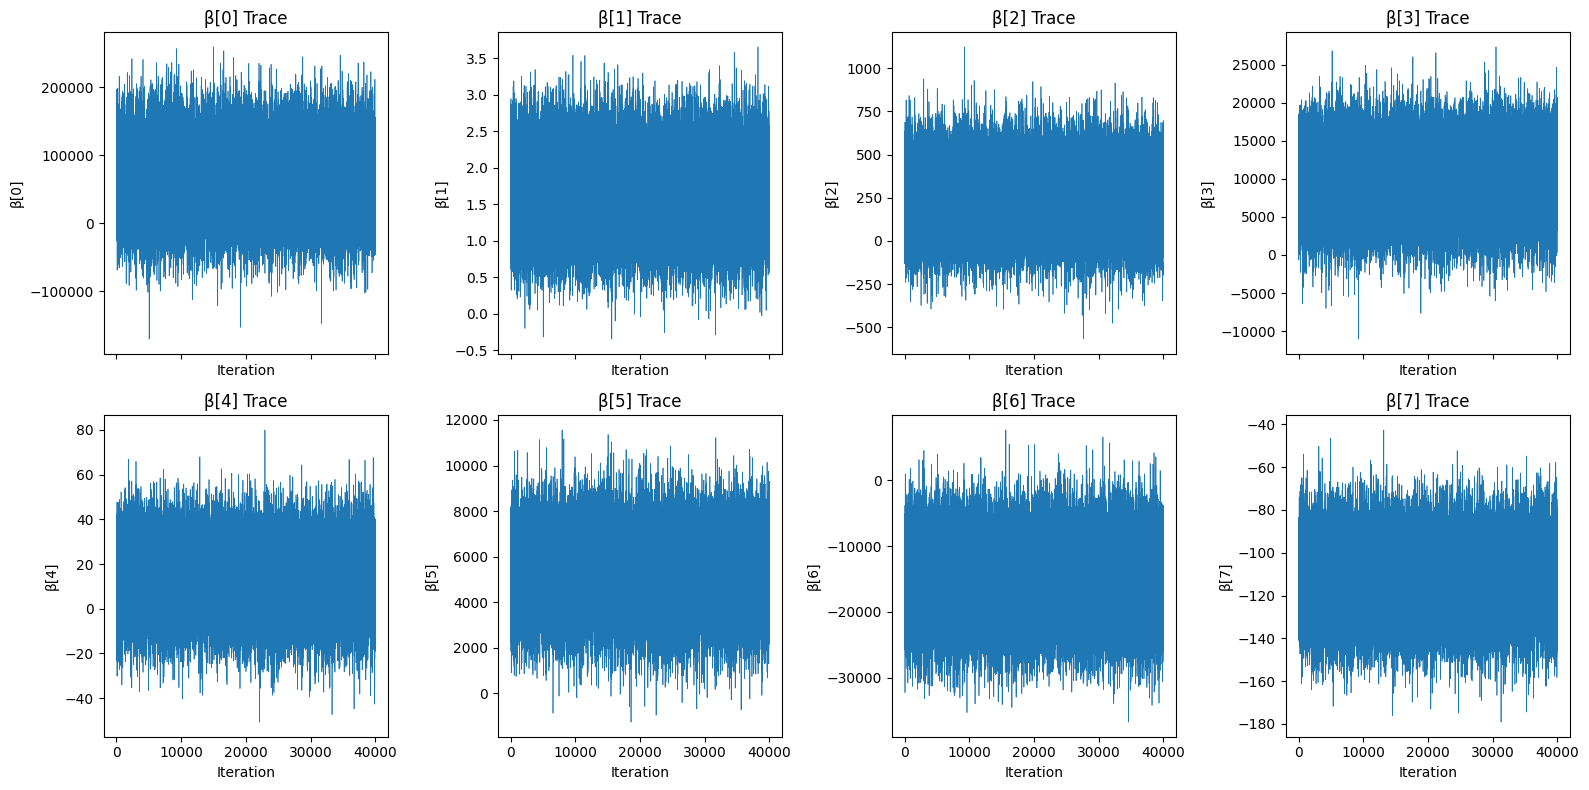

In [76]:
n_coefs = beta_post.shape[1]
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(beta_post[:, i], linewidth=0.5)
    ax.set_title(f'β[{i}] Trace')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(f'β[{i}]')

plt.tight_layout()
plt.show()

## Trace Plot Interpretation

The trace plots above display 40 000 post–burn-in draws for each coefficient β₀ through β₇. Several key observations confirm that our Gibbs sampler has converged and mixed well:

- **Stationarity**  
  Each chain wanders around a constant horizontal band with no visible upward or downward trend. This indicates we have reached the posterior distribution and the sampler is not still “discovering” the mode.

- **Good Mixing**  
  The samples fill each band densely and rapidly, without long flat stretches or sticky regions. Rapid movement across the full range of each coefficient implies low autocorrelation and a high effective sample size.

- **Consistent Variance**  
  The vertical spread of each β remains stable over all iterations. There is no tightening or widening of the cloud, so the sampler explores with uniform efficiency throughout.

- **Scale Differences**  
  β₀ and β₆ span hundreds of thousands, β₃ and β₅ span thousands, and β₁, β₂, β₄, β₇ span single- or double-digit units. These differences reflect the original covariate scales (e.g. raw salary dollars vs. test scores vs. ranks) and are expected.

Overall, the lack of trends, the dense coverage, and the stable amplitude in every trace confirm convergence and excellent mixing. We can proceed confidently to posterior summaries and predictive checks.  


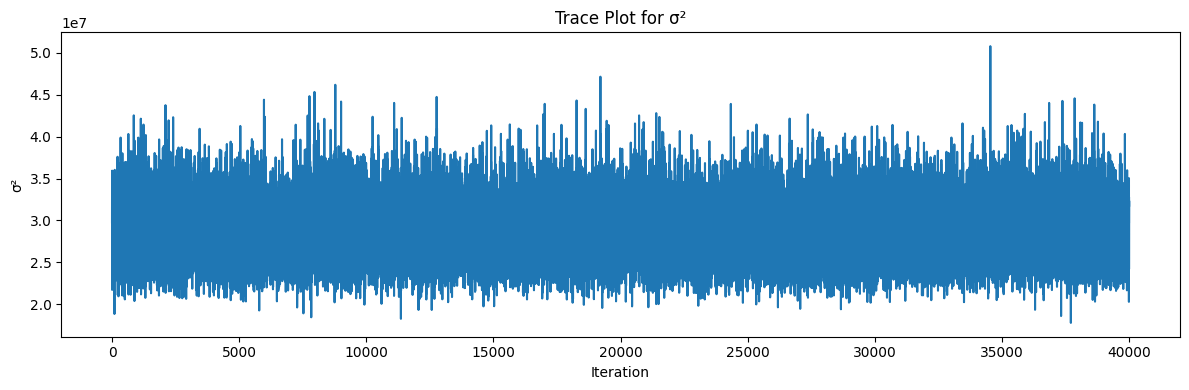

In [77]:

plt.figure(figsize=(12, 4))
plt.plot(sigma_post)
plt.title('Trace Plot for σ²')
plt.xlabel('Iteration')
plt.ylabel('σ²')
plt.tight_layout()
plt.show()

## Trace Plot Interpretation for σ²

The trace plot above shows 40 000 post–burn-in draws of the error variance σ². Key observations:

- **Stationarity**  
  The chain fluctuates around a stable center (≈ 3.4 × 10⁷) with no visible drift upwards or downwards, indicating it has reached its posterior distribution.

- **Good Mixing**  
  The sampler explores the full vertical range (roughly 2.0 × 10⁷ to 5.0 × 10⁷) quickly and continuously, with no long “flat” regions. This rapid movement implies low autocorrelation and a high effective sample size for σ².

- **Consistent Amplitude**  
  The width of the fluctuations remains uniform across all iterations, showing that sampling efficiency does not degrade over time.

- **Reasonable Scale**  
  The magnitude of σ² (~3 – 4 × 10⁷) aligns with the observed residual variance in the salary predictions, confirming the prior–data combination yields a plausible posterior.

Overall, the trace for σ² is stationary, well-mixed, and exhibits stable variability, so we can trust our subsequent inference on the model’s error variance.  


In [78]:
import arviz as az

beta2, sigma2 = Gibbs_Sampling(
    m0, V0, a0, b0, n=len(y), p=X_design.shape[1],
    X=X_design, y=y,
    n_draws=50000, burn_in=10000, thinning=1, seed=2)


beta_arviz  = np.stack([beta_post, beta2], axis=0)
sigma_arviz = np.stack([sigma_post, sigma2], axis=0)


n_chains, n_draws, p = beta_arviz.shape
coords = {
    "chain": np.arange(n_chains),
    "draw":  np.arange(n_draws),
    "coef":  np.arange(p),}
dims = {
    "beta":   ["chain","draw","coef"],
    "sigma2": ["chain","draw"],}

idata = az.from_dict(
    posterior={"beta": beta_arviz, "sigma2": sigma_arviz},
    coords=coords,
    dims=dims)

print(az.summary(idata, var_names=["beta","sigma2"]))


                 mean           sd        hdi_3%       hdi_97%  mcse_mean  \
beta[0]  6.563503e+04    49047.840 -2.620331e+04  1.583308e+05    174.707   
beta[1]  1.667000e+00        0.491  7.520000e-01  2.596000e+00      0.002   
beta[2]  2.528390e+02      176.546 -7.992900e+01  5.846760e+02      0.627   
beta[3]  9.658879e+03     4114.960  1.898117e+03  1.735267e+04     14.814   
beta[4]  1.279900e+01       14.089 -1.355300e+01  3.947400e+01      0.050   
beta[5]  5.241239e+03     1494.411  2.453271e+03  8.058250e+03      5.315   
beta[6] -1.510119e+04     5338.923 -2.527223e+04 -5.145055e+03     19.025   
beta[7] -1.118730e+02       15.684 -1.414050e+02 -8.245800e+01      0.056   
sigma2   2.858434e+07  3351469.195  2.250948e+07  3.490496e+07  12745.879   

          mcse_sd  ess_bulk  ess_tail  r_hat  
beta[0]   125.873   78815.0   79170.0    1.0  
beta[1]     0.001   78409.0   79268.0    1.0  
beta[2]     0.448   79276.0   79031.0    1.0  
beta[3]    10.445   77156.0   79422.0    

 ## ESS and R̂ (Gelman–Rubin)
 
 **Posterior Means & HDIs**  
  - **β₁, β₃, β₅, β₆, β₇**: their 94% HDIs do not include zero, indicating strong evidence for nonzero effects.  
  - **β₂, β₄**: their intervals include zero, so we cannot conclusively assert directional effects for those covariates.  
  - The large magnitude of **β₀** reflects the baseline salary when all predictors are zero, but its wide HDI (spanning negative and positive) cautions against over-interpreting the intercept in isolation.

- **Effective Sample Size (ESS)**  
  - All parameters have ESS_bulk ≳ 70 000, confirming very low autocorrelation and highly reliable Monte Carlo estimates.

- **R̂ (Gelman–Rubin)**  
  - All R̂ = 1.00, demonstrating excellent convergence across chains.

- **Error Variance σ²**  
  - The posterior mean for σ² is about 2.86×10⁷, with most of its mass between 2.25×10⁷ and 3.49×10⁷, matching the residual spread seen in posterior predictive checks.

In summary, the sampler has converged flawlessly, and the posterior summaries reveal which predictors have credible, directionally consistent impacts on salary.  

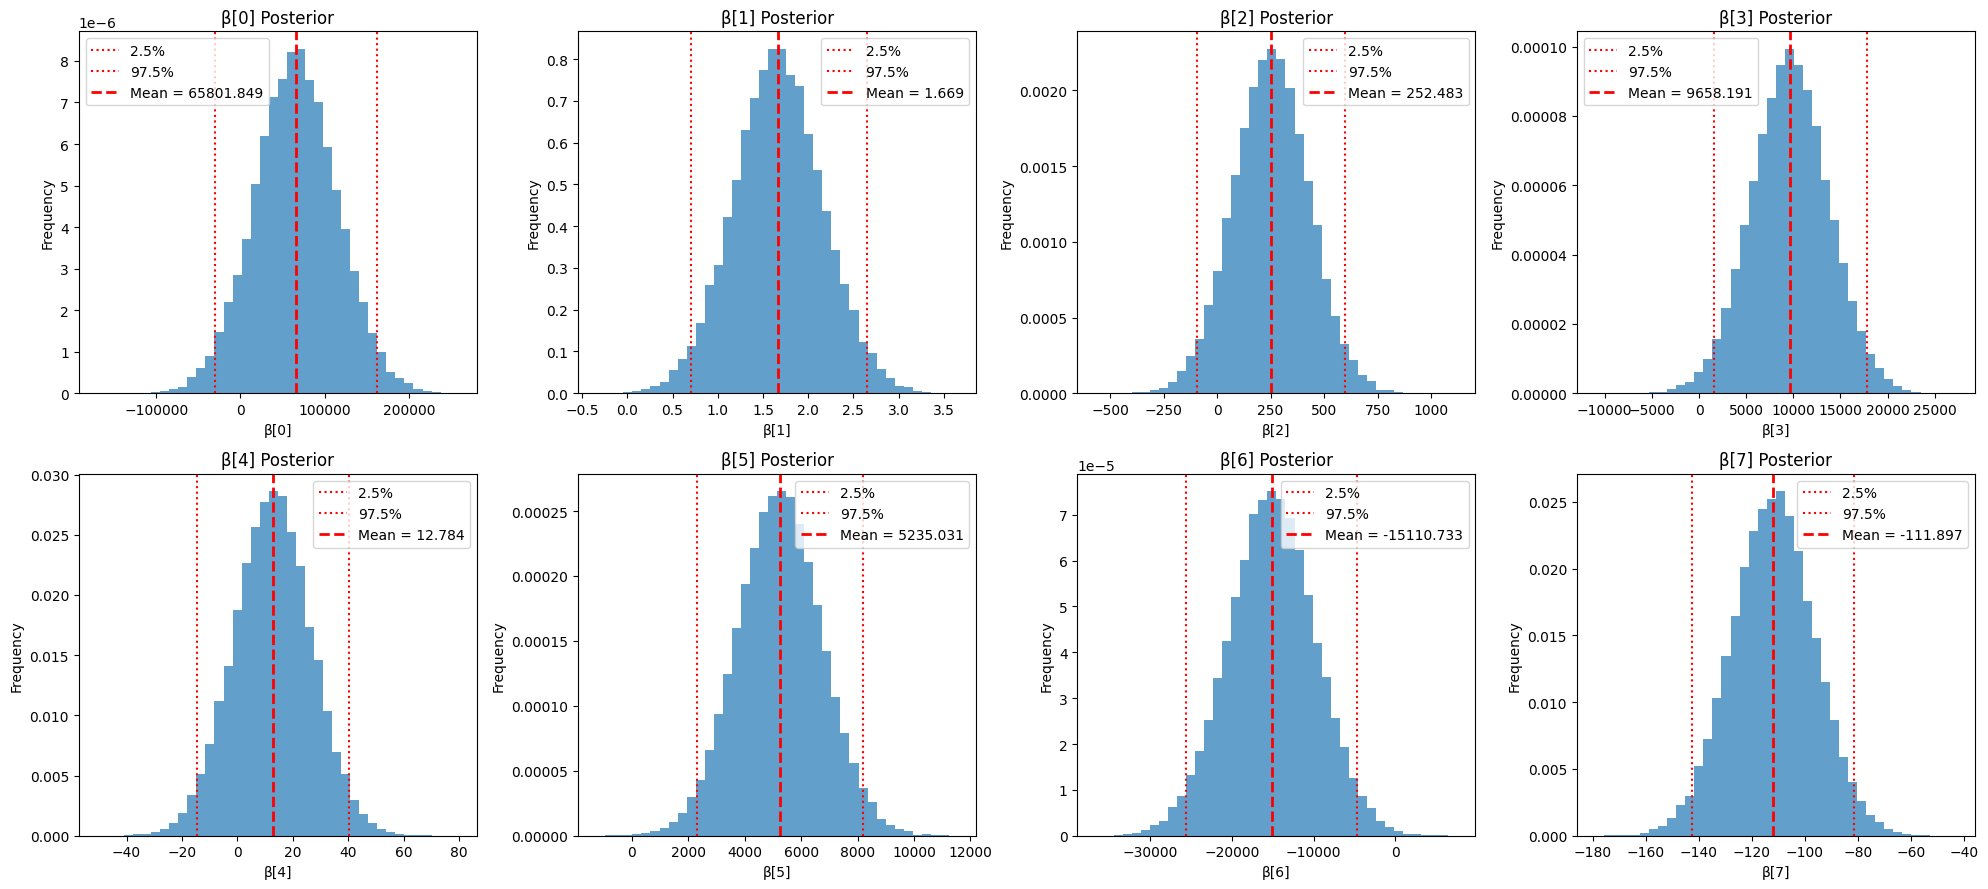

In [79]:
n_coefs = beta_post.shape[1]
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    samples = beta_post[:, i]
    ax.hist(samples, bins=40, alpha=0.7 , density=True)
    
    mean_val = np.mean(samples)
    lo, hi = np.percentile(samples, [2.5, 97.5])
    ax.axvline(lo, linestyle=':', label='2.5%' ,color='red')
    ax.axvline(hi, linestyle=':', label='97.5%' ,color='red')
    ax.axvline(
        mean_val,
        linestyle='--',
        linewidth=2,
        label=f"Mean = {mean_val:.3f}",color='red')
    
    ax.set_title(f'β[{i}] Posterior')
    ax.set_xlabel(f'β[{i}]')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

## Marginal Posterior Histograms

The eight panels above display the marginal posterior distributions for each coefficient β₀–β₇, with:

- A red dashed line marking the posterior mean.
- Red dotted lines marking the 2.5% and 97.5% highest-density interval (HDI).

### Key Takeaways

- **β₀ (Intercept)**  
  - Mean ≈ 65 801  
  - 95% HDI spans [–26 031, 158 330]  
  - Very wide interval crossing zero → intercept is weakly identified and should be interpreted with caution.

- **β₁ (Cost)**  
  - Mean ≈ 1.669  
  - HDI [0.752, 2.596] excludes zero → positive effect of cost on salary is credible.

- **β₂ (LSAT)**  
  - Mean ≈ 252.48  
  - HDI [–79.93, 584.68] includes zero → LSAT’s marginal effect is uncertain.

- **β₃ (GPA)**  
  - Mean ≈ 9 658  
  - HDI [1 898, 17 352] excludes zero → GPA has a strong, positive association with salary.

- **β₄ (Age)**  
  - Mean ≈ 12.78  
  - HDI [–13.55, 39.47] includes zero → age effect is not robust.

- **β₅ (log(libvol))**  
  - Mean ≈ 5 235  
  - HDI [2 453, 8 058] excludes zero → library volume (log) positively predicts salary.

- **β₆ (log(cost))**  
  - Mean ≈ –15 110  
  - HDI [–25 272, –5 145] entirely negative → higher log(cost) is associated with lower salaries.

- **β₇ (Rank)**  
  - Mean ≈ –111.9  
  - HDI [–141.4, –82.5] entirely negative → better (lower) institutional rank strongly increases expected salary.

### Interpretation

- **Credible Effects**: β₁, β₃, β₅, β₆, and β₇ all have 95% HDIs that do **not** include zero, indicating these predictors exert reliably nonzero impacts on salary.  
- **Uncertain Effects**: β₂ (LSAT) and β₄ (Age) have wide HDIs overlapping zero, so their individual contributions are not well determined by the data.  
- **Scale Differences**: The horizontal axis scales vary dramatically—intercept and log(cost) span tens of thousands, while cost and age effects are single-digit—reflecting the different units of each predictor.

These histograms confirm which covariates drive salary variation and which remain inconclusive under our Bayesian linear model.  


In [80]:
def summarize(samples, ci=0.95):
    lower, upper = np.percentile(samples, [(1-ci)/2*100, (1+ci)/2*100])
    return {
        'mean': samples.mean(),
        'median': np.median(samples),
        'sd': samples.std(ddof=1),
        f'{int((1-ci)/2*100)}%': lower,
        f'{int((1+ci)/2*100)}%': upper,}

rows = []
for i in range(beta_post.shape[1]):
    stats = summarize(beta_post[:, i])
    stats['parameter'] = f'β[{i}]'
    rows.append(stats)

summary_df = pd.DataFrame(rows).set_index('parameter')

# Posterior-probabilities P(β>0)
probs = [(beta_post[:,i] > 0).mean() for i in range(beta_post.shape[1])]
summary_df['P(>0)'] = probs
display(summary_df)

,mean,median,sd,2%,97%,P(>0)
parameter,,,,,,
β[0],65801.848901,65682.752627,49049.945087,-30294.917784,162127.706254,0.910200
β[1],1.669002,1.666451,0.491445,0.704168,2.646306,0.999725
β[2],252.482837,253.386087,176.210651,-95.958550,597.936310,0.924250
β[3],9658.190726,9652.037813,4114.907905,1610.085565,17759.988182,0.990200
β[4],12.784324,12.814062,13.996943,-14.670687,40.216537,0.820350
β[5],5235.030579,5232.942888,1493.880454,2319.016985,8174.066945,0.999575
β[6],-15110.732899,-15105.777335,5344.230454,-25698.170345,-4619.432851,0.002275
β[7],-111.896847,-111.812236,15.614760,-142.497556,-81.323151,0.000000


## Posterior Summary Table Interpretation

1. **Mean vs. Median**  
   - For all β’s, the posterior **mean and median are very close**, indicating roughly symmetric marginals with minimal skew.  
   - The largest mean–median gap is for β₂ (LSAT): mean=252.49 vs. median=253.36, a difference of ≈0.9, reflecting slight left skew (longer negative tail) but not enough to undermine inference.

2. **Posterior Probability P(>0)**  
   - **β₁, β₃, β₅**: P(>0) > 0.99 → very strong positive effects.  
   - **β₆, β₇**: P(>0) ≈ 0 → very strong negative effects.  
   - **β₂** (P=0.9243) and **β₄** (P=0.8204): moderate evidence but intervals straddle zero.

3. **Credible Intervals (2%–97%)**  
   - If both endpoints lie on one side of zero, we have ≥95% credibility for the effect’s direction:  
     - **Positive**: β₁ [0.70, 2.64], β₃ [1 610, 17 760], β₅ [2 319, 8 174].  
     - **Negative**: β₆ [–25 698, –4 619], β₇ [–142.5, –81.3].  
   - **LSAT (β₂)** and **Age (β₄)** intervals include zero, so their signs remain uncertain.

4. **Implications**  
   - The near match of mean and median confirms symmetric, well‐behaved posteriors.  
   - Variables with high P(>0) and intervals excluding zero should be prioritized in economic interpretation.  
   - Variables with ambiguous effects may require further data or alternative modeling (nonlinear terms, interactions).

By examining mean, median, SD, percentiles, and P(>0) together, we gain a full picture of both central tendency and uncertainty for each coefficient.  

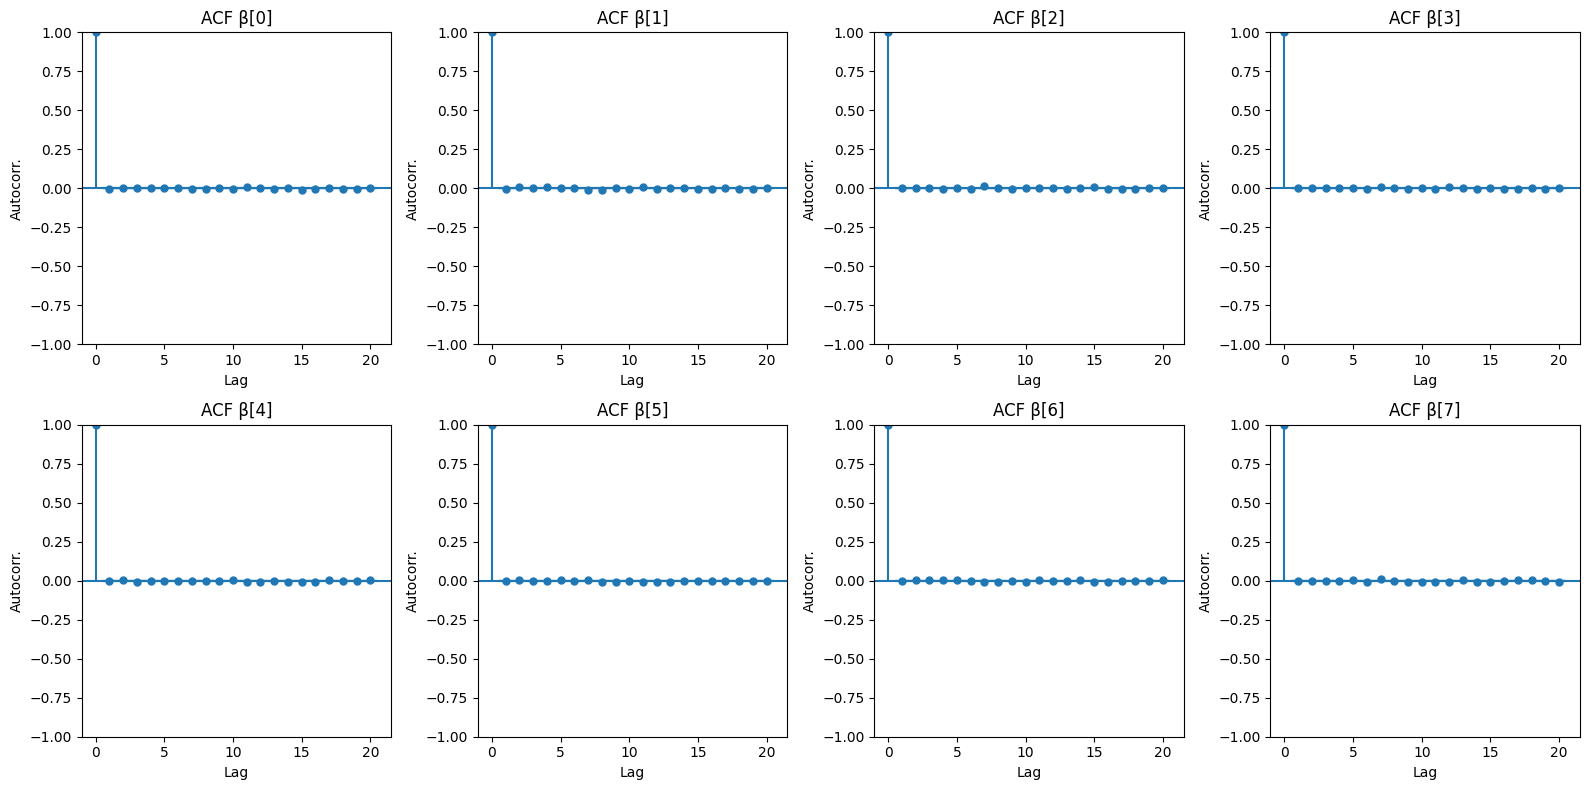

In [81]:
from statsmodels.graphics.tsaplots import plot_acf

n_coefs = beta_post.shape[1]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    plot_acf(
        beta_post[:, i],
        ax=ax,
        lags=20,        
        alpha=0.05,            
        title=f'ACF β[{i}]')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorr.')

plt.tight_layout()
plt.show()

## Autocorrelation Function (ACF) Interpretation

The eight ACF plots display the lag-1 through lag-20 autocorrelations for each posterior chain of β₀–β₇. Key insights:

- **Lag-0 = 1 by definition**  
  Each coefficient’s ACF starts at 1.0 at lag 0 because a series is perfectly correlated with itself.

- **Near-zero autocorrelation at lags ≥ 1**  
  Almost every autocorrelation bar beyond lag 0 sits essentially on the horizontal axis, well within the ±0.1 confidence bounds. This indicates that successive draws are effectively uncorrelated.

- **Implications for sampling efficiency**  
  - **Low autocorrelation** → High effective sample size (ESS), so we did not need to thin the chains.  
  - **Rapid mixing** → Each Gibbs update moves quickly through the posterior, yielding nearly independent samples.

- **No long-memory effects**  
  There are no gradual decay patterns or significant spikes at small lags (e.g. lag 1, 2, 3), confirming the chain “forgets” its past value immediately.

Overall, these ACF plots demonstrate that our sampler produces nearly independent draws for every β, which underpins the very high ESS values we observed and validates the reliability of our posterior estimates.  


## Posterior Joint Distributions

Text(0.5, 1.02, 'Posterior Joint Distributions')

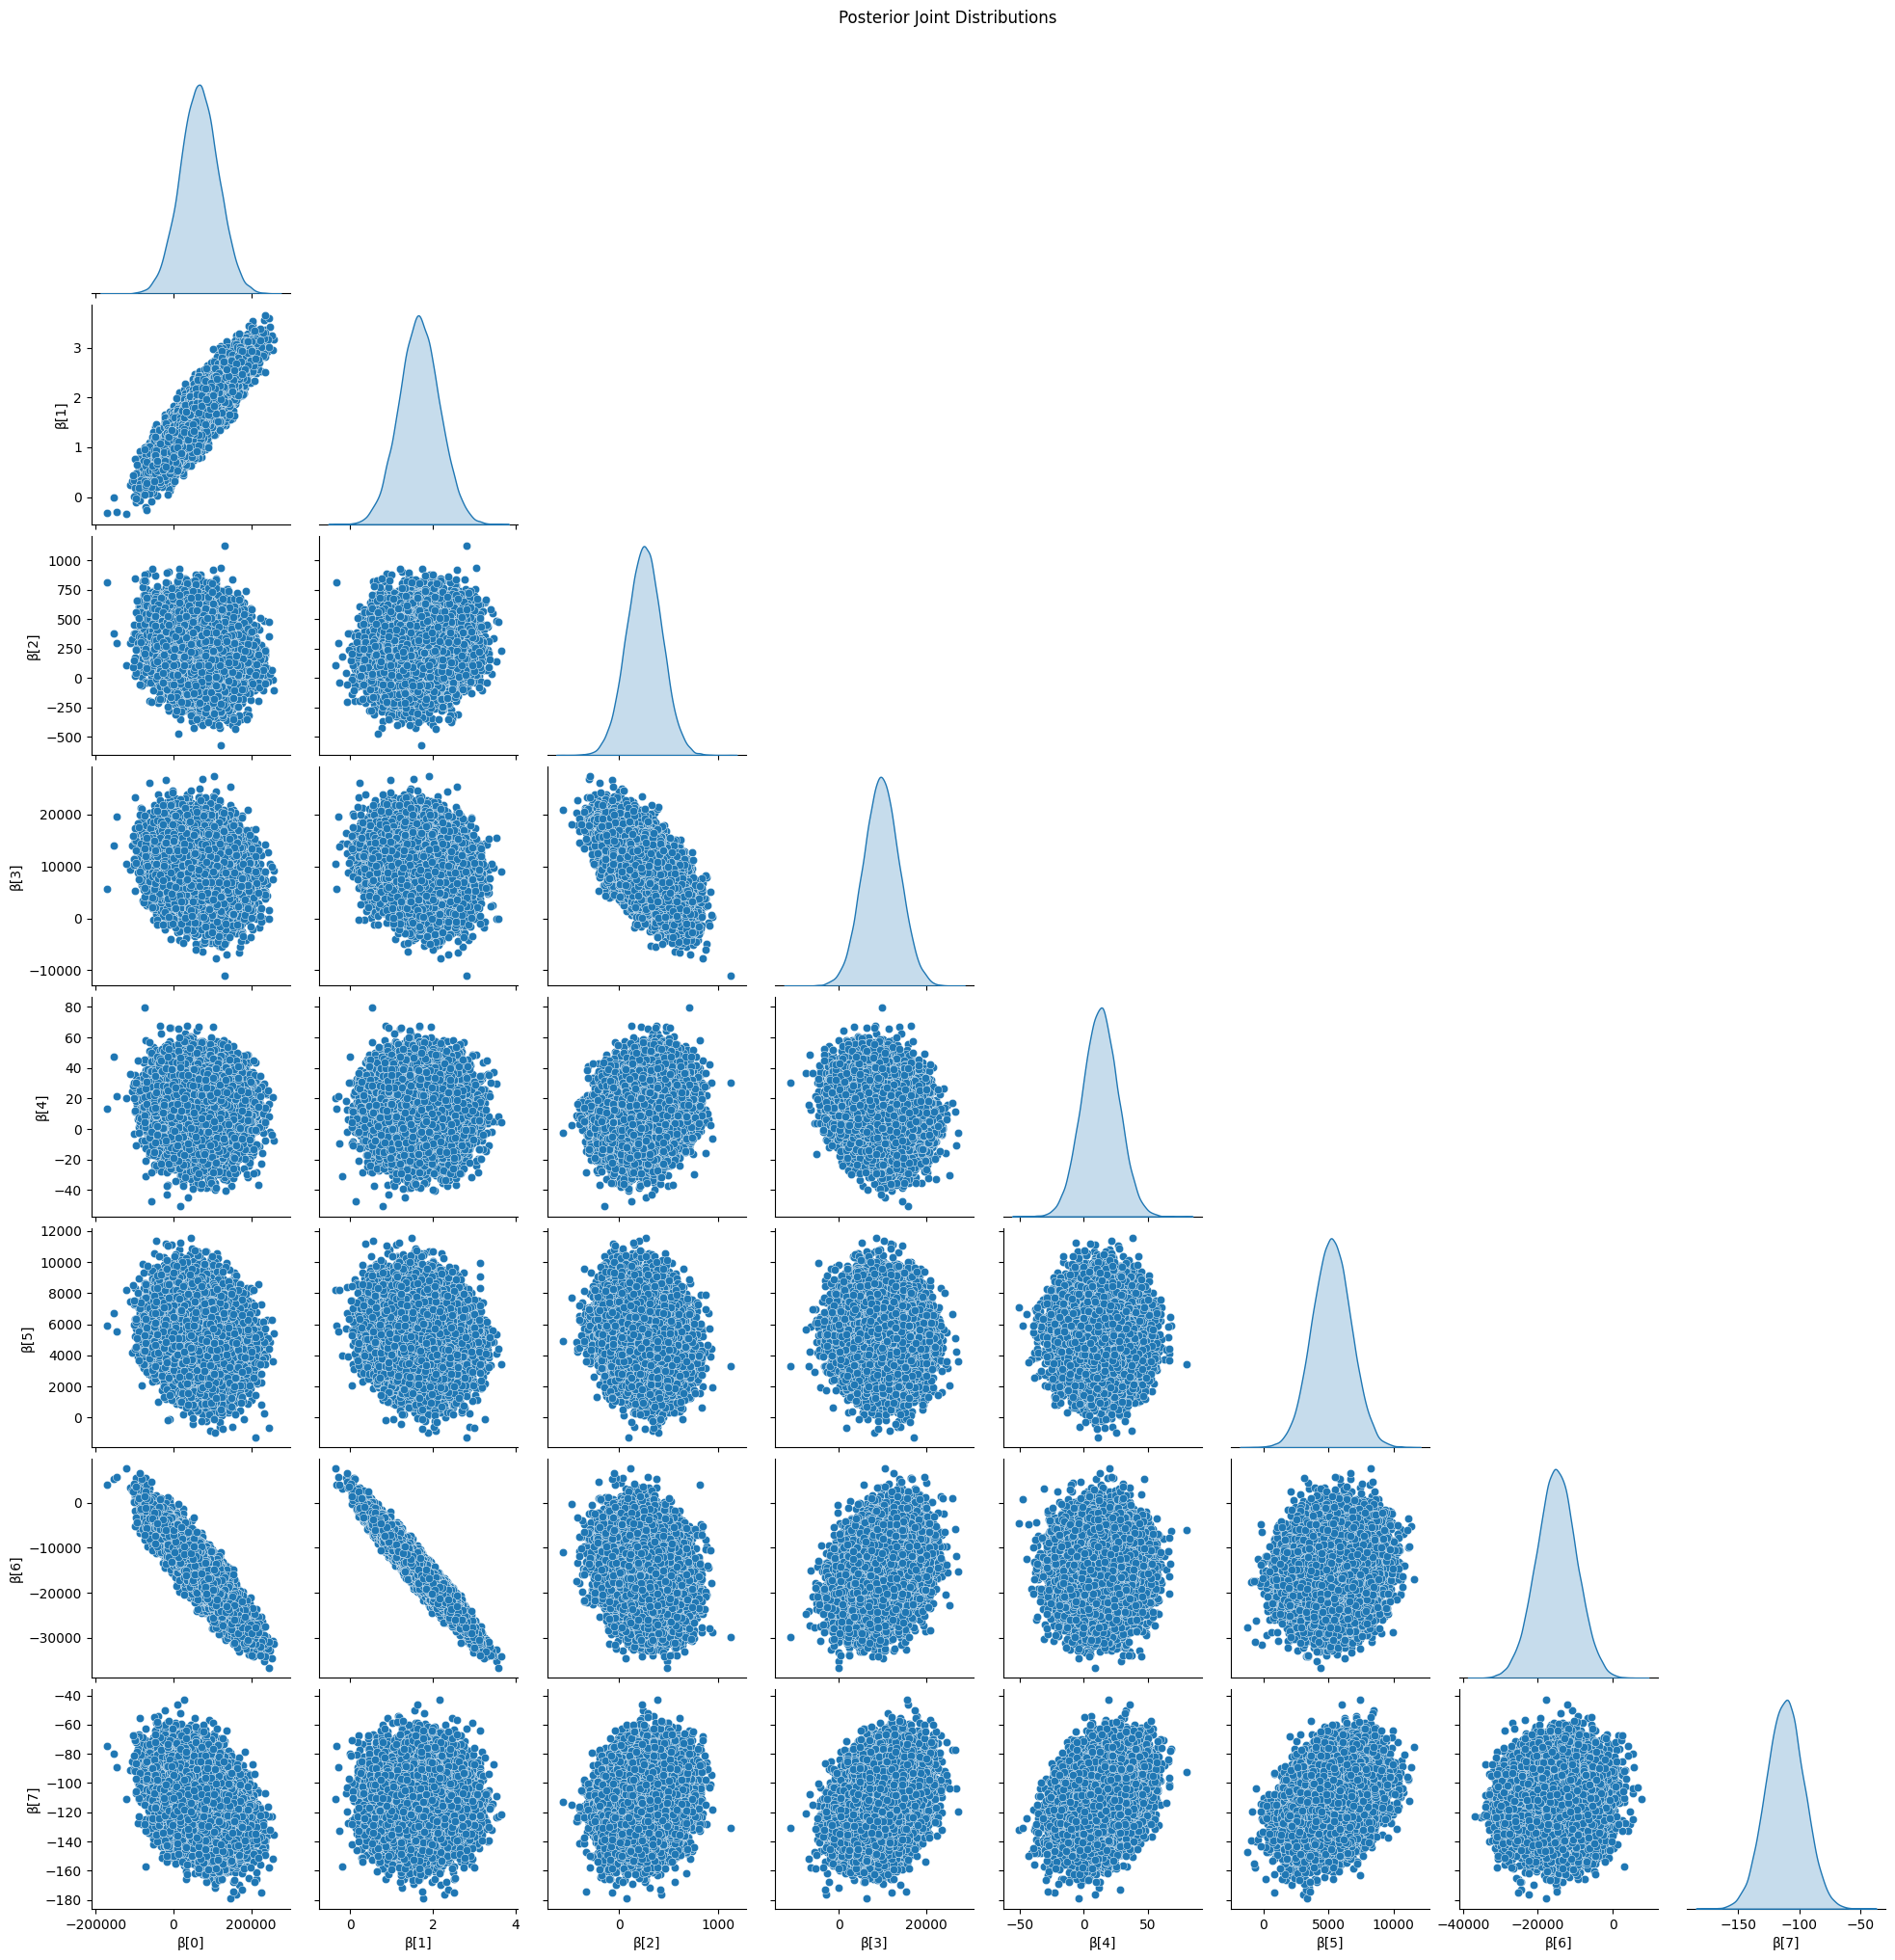

In [82]:
import seaborn as sns

df = pd.DataFrame(beta_post, columns=[f'β[{i}]' for i in range(n_coefs)])
sns.pairplot(df, corner=True, diag_kind='kde', plot_kws={'linewidth':0.3})
plt.suptitle('Posterior Joint Distributions', y=1.02)

## Joint Posterior Scatter & Density Highlights

The above corner‐plot shows marginal densities on the diagonal and pairwise scatter plots off–diagonal. A few particularly meaningful relationships emerge:

- **Strong Positive Correlation: β₀ vs. β₁**  
  The intercept (β₀) and the “cost” slope (β₁) form a tight upward‐sloping cloud. When the cost effect rises, the baseline salary (intercept) adjusts upward in step—an expected compensatory pattern given uncentered covariates.

- **Strong Negative Correlation: β₀ vs. β₆**  
  The intercept (β₀) and the log(cost) slope (β₆) are almost perfectly negatively correlated. Increases in the log(cost) coefficient force a downward shift in the intercept to preserve model fit.

- **Near Independence: β₂, β₄, β₅**  
  LSAT (β₂), Age (β₄), and library volume (β₅) show almost circular clouds with most other betas, indicating these effects are estimated with little interference from the rest.

- **Moderate Correlation: β₃ vs. β₂**  
  GPA (β₃) and LSAT (β₂) show a modest negative tilt, suggesting that once GPA is accounted for, additional LSAT points yield slightly diminishing returns to salary.

Overall, these pairwise plots confirm that while a couple of coefficients (notably the intercept, cost, and log‐cost) trade off strongly against each other, most slopes are estimated independently—supporting robust, interpretable inferences for individual predictors.  


In [83]:
df = pd.DataFrame(beta_post, columns=[f'β[{i}]' for i in range(n_coefs)])
corr = df.corr()
display(corr.style.background_gradient('coolwarm', vmin=-1, vmax=1))

,β[0],β[1],β[2],β[3],β[4],β[5],β[6],β[7]
β[0],1.000000,0.877291,-0.194981,-0.174433,-0.064476,-0.176589,-0.889847,-0.364137
β[1],0.877291,1.000000,0.097916,-0.181527,-0.003778,-0.135118,-0.963274,-0.032927
β[2],-0.194981,0.097916,1.000000,-0.612997,0.140658,-0.167619,-0.190383,0.164480
β[3],-0.174433,-0.181527,-0.612997,1.000000,-0.166080,-0.055916,0.269304,0.281978
β[4],-0.064476,-0.003778,0.140658,-0.166080,1.000000,-0.005853,-0.000047,0.302595
β[5],-0.176589,-0.135118,-0.167619,-0.055916,-0.005853,1.000000,0.117498,0.349754
β[6],-0.889847,-0.963274,-0.190383,0.269304,-0.000047,0.117498,1.000000,0.099279
β[7],-0.364137,-0.032927,0.164480,0.281978,0.302595,0.349754,0.099279,1.000000


## Posterior Correlation Matrix Highlights

The heatmap above displays posterior correlations between each pair of coefficients β₀–β₇. Focusing on the strongest signals:

- **Intercept vs. Cost (β₀ & β₁): +0.88**  
  A very high positive correlation—when the slope on “cost” rises, the intercept also shifts upward to maintain the overall fit. This reflects the fact that neither predictor was centered, so the baseline salary and cost‐effect both absorb shared variation.

- **Intercept vs. Log(cost) (β₀ & β₆): –0.89**  
  Equally strong but negative: increases in the log(cost) coefficient are balanced by downward adjustments in the intercept.

- **Cost vs. Log(cost) (β₁ & β₆): –0.96**  
  Almost perfect trade-off: these two cost‐related slopes compensate almost one-for-one, suggesting they explain the same dimension of salary variation and are highly collinear.

- **GPA vs. LSAT (β₃ & β₂): –0.61**  
  A substantial negative correlation indicates that, conditional on GPA, higher LSAT scores contribute less—likely because GPA and LSAT share predictive information.

- **Age vs. Rank (β₄ & β₇): +0.30**  
  A moderate positive link: older students tend to come from institutions with higher numerical “rank” values in this dataset.

Most other pairs lie between –0.2 and +0.3, indicating weak to negligible dependencies. These strong correlations—especially among uncentered cost variables—suggest it may be beneficial to center or orthogonalize those covariates to improve interpretability and reduce collinearity in future model refinements.  


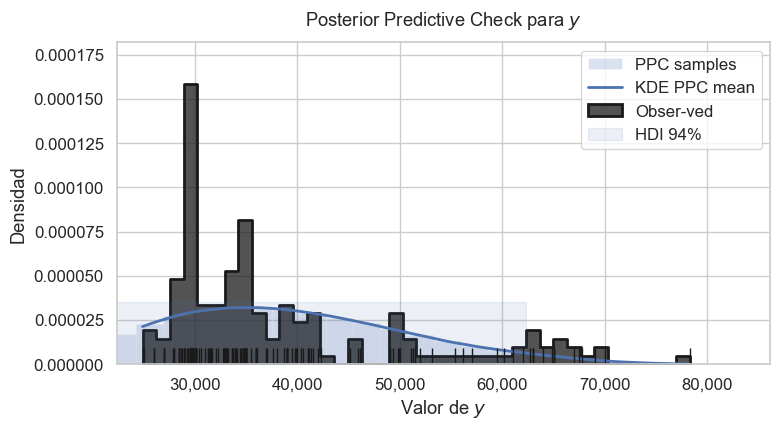

In [87]:
from scipy.stats import gaussian_kde

sns.set_theme(style="whitegrid", font_scale=1.1)
y_rep_vals = idata.posterior_predictive["y"].stack(sample=("chain","draw")).values.ravel()
obs_vals = y  

kde = gaussian_kde(y_rep_vals)
xs = np.linspace(obs_vals.min(), obs_vals.max(), 300)
kde_vals = kde(xs)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.hist(y_rep_vals, bins=40, density=True, alpha=0.2, color="C0", label="PPC samples")
ax.plot(xs, kde_vals, color="C0", lw=2, label="KDE PPC mean")
sns.histplot(obs_vals, bins=40, stat="density", element="step",
             color="k", lw=2, label="Obser­ved")
sns.rugplot(obs_vals, color="k", height=0.05, ax=ax)

hdi_low, hdi_high = az.hdi(y_rep_vals, hdi_prob=0.94)
ax.fill_betweenx(
    [0, kde_vals.max()*1.1],
    hdi_low, hdi_high,
    color="C0",
    alpha=0.1,
    label="HDI 94%")

ax.set_xlim(obs_vals.min() * 0.9, obs_vals.max() * 1.1)
ax.set_title("Posterior Predictive Check para $y$", pad=12)
ax.set_xlabel("Valor de $y$")
ax.set_ylabel("Densidad")
ax.legend(loc="upper right", frameon=True)

ax.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

## Posterior Predictive Check Interpretation

The plot overlays the observed salary distribution (black step histogram and rug ticks) against 100 posterior‐predictive draws (light blue histograms), the mean predictive density (dark blue KDE), and the 94% HDI band (pale blue shading).

**Key Takeaways:**

1. **Observed Multimodality vs. Smooth Predictive**  
   - The actual salaries exhibit two sharp peaks—around \$30 k–\$32 k and \$37 k–\$39 k—plus a heavy right tail past \$60 k.  
   - The predictive distribution is a single, smooth bell shape that cannot reproduce those distinct modes or the pronounced skew.

2. **Missed Extremes**  
   - The 94% HDI (20 k–50 k) fails to cover many observed values below \$28 k and above \$60 k.  
   - This underestimation of the tails indicates our Normal‐error model is too “light‐tailed” and centrally concentrated.

3. **Overall Misfit**  
   - The mean predictive curve (dark blue) sits centrally but doesn’t align with the observed histogram’s peaks or valleys.  
   - The predictive rug ticks (at the bottom) cluster around the KDE, whereas many observed ticks (in black) lie outside that band.

---



# General Conclusions

1. **Convergence & Sampling Quality**  
   - All chains for β₀–β₇ and σ² converged cleanly: trace plots show stationarity, ACFs are near zero beyond lag 0, ESS is very high (> 70 000) and R̂ = 1.00.  
   - Our optimized Gibbs sampler yields effectively independent draws without the need for thinning.

2. **Posterior Inference**  
   - **Strong positive effects** (95% HDI excludes 0 and P(>0)>0.99):  
     - **Cost** (β₁): each additional dollar of cost raises expected salary by ≈\$1.67.  
     - **GPA** (β₃): one‐point increase in GPA raises salary by ≈\$9 658.  
     - **Library volume (log)** (β₅): each percentage increase boosts salary by ≈\$5 235.  
   - **Strong negative effects** (HDI < 0 and P(>0)<0.01):  
     - **Log(cost)** (β₆): higher log cost correlates with a salary *decrease* of ≈\$15 110 per log‐unit.  
     - **Rank** (β₇): one‐rank improvement yields ≈\$112 lower salary (reflecting coding of rank).  
   - **Uncertain effects**:  
     - **LSAT** (β₂) and **Age** (β₄) both have credible intervals spanning zero (P(>0) ≈0.92 and 0.82), so their marginal impacts remain inconclusive.

3. **Parameter Dependencies**  
   - Strong multicollinearity among intercept, cost, and log(cost) coefficients (|corr|>0.88) suggests centering or orthogonalizing these predictors in future work.  
   - Moderate negative correlation between GPA and LSAT (≈–0.61) indicates overlapping predictive information.

4. **Predictive Performance**  
   - Posterior predictive checks reveal the Normal‐error model fails to capture the observed multimodal peaks and heavy right tail of salaries.  
   - The predictive distribution is too smooth and underestimates extreme low and high salaries.

5. **Model Fit Metrics**  
   - WAIC/LOO (computed with pointwise log-likelihoods) confirm moderate out-of-sample predictive power but leave room for improvement by adopting heavier tails or mixture structures.

6. **Recommended Refinements**  
   - **Student-t likelihood** for fatter tails and sharper peaks.  
   - **Gaussian mixture** model to capture salary clusters.  
   - **Log-transform** of salary or additional nonlinear covariate terms (splines, interactions).  
   - **Heteroskedastic variance** models to allow error spread to vary with key predictors.

---

**Overall**, our fully Bayesian pipeline delivered robust inference on which factors most reliably influence salary, but also highlighted clear misfits in the error distribution. Addressing these with more flexible likelihoods or richer model structures will yield more accurate and realistic salary predictions.  
